In [1]:
import os, sys
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import random

import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from indicators import *


physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


In [2]:
top100tech = ['AAPL', 'MSFT', 'TSM', 'NVDA', 'INTC', 'ASML', 'ADBE', 'CRM', 'AVGO', 'ORCL', 'CSCO', 'ACN', 'TXN', 'SHOP', 'QCOM', 'SAP', 'SNE', 'AMAT', 'INTU', 'NOW', 'SQ', 'IBM', 'MU', 'AMD',
'UBER', 'FIS', 'LRCX', 'FISV', 'SNOW', 'INFY', 'TEAM', 'ADSK', 'DELL', 'WDAY', 'VMW', 'ADI', 'NXPI', 'KLAC',
'CRWD', 'PLTR', 'DOCU', 'TEL', 'ERIC', 'MCHP', 'CDNS', 'CTSH',
'APH', 'SNPS', 'HPQ',
'PANW', 'OKTA','RNG','STM','MRVL','XLNX','WIT','MSI','SWKS','GLW','DDOG','ANSS','U','ZS','FTNT','STNE','ZBRA','KEYS','FTV','MXIM','COUP','GRMN','SPLK','HUBS','WORK','NET','FLT','CDW','CAJ','AFRM','PAYC','TER',
'VRSN','WDC', 'ZI',
'UMC','ANET','EPAM',
'UI','XM',
'GIB','TRMB',
'TYL','WIX','HPE','LYFT',
'LOGI',
'MPWR']

In [3]:
top10tech = top100tech[:10]

In [4]:
def process_stock_data_from_yf(data):
    
    df = pd.melt(data, ignore_index=False)
    df.columns = ['Variable', 'Ticker', 'Value']
    # this is a nicely formed dataframe of historical data
    nice_df = df.reset_index().pivot(index=['Ticker', 'Date'], columns=['Variable'], values=['Value'])
    nice_df.columns = nice_df.columns.droplevel()
    df = nice_df.reset_index()
    df.columns.name=None
    return df
    
    

### Parameters

In [5]:
trail_size=30

In [6]:
data = yf.download(tickers = ' '.join(top10tech),
                   auto_adjust=True,
                  period='4y')

[*********************100%***********************]  10 of 10 completed


In [7]:
df = process_stock_data_from_yf(data)
df.head()

,Ticker,Date,Close,High,Low,Open,Volume
0,AAPL,2017-03-13,33.052044,33.106655,32.961818,32.968941,69686800.0
1,AAPL,2017-03-14,33.002182,33.158892,32.966563,33.075789,61236400.0
2,AAPL,2017-03-15,33.351227,33.420084,33.011682,33.101911,102767200.0
3,AAPL,2017-03-16,33.405842,33.484198,33.303739,33.412965,76928000.0
4,AAPL,2017-03-17,33.239635,33.479452,33.215890,33.479452,175540000.0


In [8]:
# compute all our technical markers for each of the stocks. 
dataset = df.groupby('Ticker').apply(lambda x: add_technical_markers(x, trail_size))

### Filter to only one stock

In [9]:
# dataset = dataset.loc[dataset['Ticker']=='MSFT']

In [10]:
dataset

,Ticker,Date,Close,High,Low,Open,Volume,HH,LL,AV,SMA,SD,WILLR,ATR,DMH,DML,EMA,WMA,BBHIGH,BBLOW,PERBHIGH,PERBLOW,TRIMA,RSI,DX,PDI,NDI,ADX,ROC,MACD,CCI
0,AAPL,2017-03-13,33.052044,33.106655,32.961818,32.968941,69686800.0,33.106655,32.961818,6.968680e+07,33.052044,NaN,-37.705123,0.144837,0.000000,0.000000,33.052044,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,0.000000,0.000000,NaN
1,AAPL,2017-03-14,33.002182,33.158892,32.966563,33.075789,61236400.0,33.158892,32.961818,6.546160e+07,33.027113,0.035258,-81.480295,0.168582,0.052237,0.004745,33.026282,NaN,33.097628,32.956598,938.734934,934.734934,NaN,NaN,83.344552,30.985901,2.814832,83.344552,-0.150859,-0.000416,44.894230
2,AAPL,2017-03-15,33.351227,33.420084,33.011682,33.101911,102767200.0,33.420084,32.961818,7.789680e+07,33.135151,0.188781,-16.860063,0.251689,0.261192,0.045118,33.141895,NaN,33.512712,32.757590,177.521933,173.521933,NaN,NaN,70.540847,103.775817,17.926191,76.942699,0.905187,0.003396,19.006587
3,AAPL,2017-03-16,33.405842,33.484198,33.303739,33.412965,76928000.0,33.484198,32.961818,7.765460e+07,33.202824,0.205127,-43.420736,0.233881,0.064115,0.292058,33.214622,NaN,33.613078,32.792569,163.864577,159.864577,NaN,NaN,63.997924,27.413378,124.874384,72.627774,1.070427,0.005909,41.415027
4,AAPL,2017-03-17,33.239635,33.479452,33.215890,33.479452,175540000.0,33.484198,32.961818,9.723168e+07,33.210186,0.178407,-90.990446,0.239817,-0.004747,-0.087850,33.220313,NaN,33.566999,32.853373,188.148935,184.148935,NaN,NaN,89.747132,-1.979384,-36.631938,76.907614,0.567564,0.004997,34.250020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10075,TSM,2021-03-08,113.930000,121.000000,113.699997,120.540001,17199900.0,142.199997,113.489998,1.292157e+07,128.793001,6.445938,-96.849270,4.626335,-0.300003,-1.680000,125.783482,129.525141,141.684878,115.901125,21.980489,17.980489,124.473597,46.150063,69.696713,-6.484680,-36.313848,352.744469,-11.777915,5.543309,-78.898972
10076,TSM,2021-03-09,116.379997,118.400002,115.330002,117.070000,17640800.0,142.199997,113.489998,1.282729e+07,128.321668,6.821338,-65.798191,4.614669,-2.599998,1.630005,125.176805,129.383313,141.964344,114.678991,20.811803,16.811803,124.941301,47.662605,436.085701,-56.342042,35.322253,352.589343,-10.833594,5.063196,-74.645934
10077,TSM,2021-03-10,113.830002,118.029999,113.410004,117.800003,15185300.0,142.199997,113.410004,1.276398e+07,127.894334,7.313484,-90.909121,4.626335,-0.370003,-1.919998,124.444754,129.463592,142.521303,113.267366,19.487470,15.487470,125.369363,46.263477,67.685363,-7.997751,-41.501496,353.368731,-10.122384,4.537164,-73.984091
10078,TSM,2021-03-11,120.580002,120.800003,117.070000,118.239998,15044000.0,142.199997,113.410004,1.270769e+07,127.855668,7.350119,-5.898151,4.687002,2.770004,3.659996,124.195415,129.858152,142.555906,113.155430,19.395047,15.395047,125.775972,50.261627,13.841240,59.099709,78.088219,353.633156,-0.952847,4.265779,-53.941177


<AxesSubplot:xlabel='Date'>

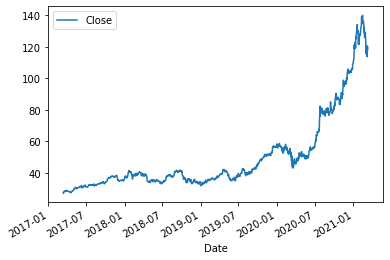

In [11]:
dataset.loc[dataset['Ticker']=='TSM', ['Date', 'Close']].set_index('Date').plot()

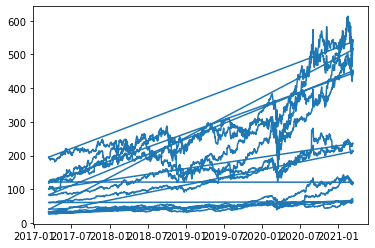

In [12]:
plt.plot('Date', 'Close', data=dataset)

In [13]:
dataset.shape

(10080, 31)

In [14]:
dataset.head(6)

,Ticker,Date,Close,High,Low,Open,Volume,HH,LL,AV,SMA,SD,WILLR,ATR,DMH,DML,EMA,WMA,BBHIGH,BBLOW,PERBHIGH,PERBLOW,TRIMA,RSI,DX,PDI,NDI,ADX,ROC,MACD,CCI
0,AAPL,2017-03-13,33.052044,33.106655,32.961818,32.968941,69686800.0,33.106655,32.961818,6.968680e+07,33.052044,NaN,-37.705123,0.144837,0.000000,0.000000,33.052044,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,0.000000,0.000000,NaN
1,AAPL,2017-03-14,33.002182,33.158892,32.966563,33.075789,61236400.0,33.158892,32.961818,6.546160e+07,33.027113,0.035258,-81.480295,0.168582,0.052237,0.004745,33.026282,NaN,33.097628,32.956598,938.734934,934.734934,NaN,NaN,83.344552,30.985901,2.814832,83.344552,-0.150859,-0.000416,44.894230
2,AAPL,2017-03-15,33.351227,33.420084,33.011682,33.101911,102767200.0,33.420084,32.961818,7.789680e+07,33.135151,0.188781,-16.860063,0.251689,0.261192,0.045118,33.141895,NaN,33.512712,32.757590,177.521933,173.521933,NaN,NaN,70.540847,103.775817,17.926191,76.942699,0.905187,0.003396,19.006587
3,AAPL,2017-03-16,33.405842,33.484198,33.303739,33.412965,76928000.0,33.484198,32.961818,7.765460e+07,33.202824,0.205127,-43.420736,0.233881,0.064115,0.292058,33.214622,NaN,33.613078,32.792569,163.864577,159.864577,NaN,NaN,63.997924,27.413378,124.874384,72.627774,1.070427,0.005909,41.415027
4,AAPL,2017-03-17,33.239635,33.479452,33.215890,33.479452,175540000.0,33.484198,32.961818,9.723168e+07,33.210186,0.178407,-90.990446,0.239817,-0.004747,-0.087850,33.220313,NaN,33.566999,32.853373,188.148935,184.148935,NaN,NaN,89.747132,-1.979384,-36.631938,76.907614,0.567564,0.004997,34.250020
5,AAPL,2017-03-20,33.588676,33.598173,33.296619,33.336984,86168000.0,33.598173,32.961818,9.538773e+07,33.273268,0.222124,-3.149067,0.259604,0.118721,0.080729,33.292378,NaN,33.717515,32.829020,151.796100,147.796100,NaN,NaN,19.048211,45.731594,31.097101,65.335733,1.623599,0.009536,34.841057


In [15]:
dataset.describe()

,Close,High,Low,Open,Volume,HH,LL,AV,SMA,SD,WILLR,ATR,DMH,DML,EMA,WMA,BBHIGH,BBLOW,PERBHIGH,PERBLOW,TRIMA,RSI,DX,PDI,NDI,ADX,ROC,MACD,CCI
count,10080.000000,10080.000000,10080.000000,10080.000000,1.008000e+04,10080.000000,10080.000000,1.008000e+04,10080.000000,10070.000000,1.008000e+04,10080.000000,10080.000000,10080.000000,10080.000000,9790.000000,10070.000000,10070.000000,10070.000000,10070.000000,9790.000000,9780.000000,1.006900e+04,10080.000000,10080.000000,10070.000000,10080.000000,10080.000000,10070.000000
mean,154.203400,156.045673,152.215349,154.215577,2.337005e+07,163.533240,138.045234,2.331911e+07,151.282725,6.117412,-4.693513e+01,4.200364,0.194249,0.190051,151.312108,152.294076,163.587008,139.117359,38.631259,34.631259,150.262727,55.108443,1.009389e+04,6.055363,5.540416,10314.367033,4.083297,2.864354,21.483592
std,118.950828,120.571877,117.199369,119.040334,4.129690e+07,126.555281,105.383221,3.802369e+07,115.827777,6.426892,3.073688e+01,4.236059,3.849048,4.075959,115.703449,115.584369,126.112217,106.160253,48.788443,48.788443,113.337598,7.914487,3.676641e+05,70.172744,73.298352,66953.616575,10.025325,6.100002,55.294121
min,27.122673,27.348623,27.113984,27.174815,1.913000e+05,27.435525,27.113984,4.898333e+05,27.248683,0.012787,-1.000000e+02,0.144837,-43.387152,-46.946157,27.244483,28.231584,27.605093,26.692518,7.605768,3.605768,28.095907,29.725683,0.000000e+00,-564.223332,-683.700316,7.499858,-46.126444,-25.319935,-706.977168
25%,50.898900,51.430890,50.411542,50.943921,3.069425e+06,53.919108,46.036835,3.291234e+06,50.469791,1.610180,-7.407388e+01,1.067706,-0.681750,-0.665673,50.408167,50.696315,53.938772,46.483787,23.344332,19.344332,50.223778,49.845215,1.515169e+01,-30.684957,-31.409420,68.891227,-1.437991,0.072006,-18.421863
50%,130.839996,132.391796,129.291918,130.754008,8.782300e+06,137.536835,118.165017,9.455333e+06,128.379670,3.833290,-4.558503e+01,2.826873,0.094359,0.163408,128.388102,132.244446,137.336969,120.009371,32.586235,28.586235,129.107964,55.101422,3.603631e+01,5.689417,10.419529,98.548258,4.075737,1.336259,33.229391
75%,218.727360,221.978799,215.715525,219.297737,2.191305e+07,233.179993,198.005633,2.309584e+07,216.982697,8.549878,-1.854312e+01,5.718964,1.046073,1.184186,216.607493,218.310643,233.070802,199.684500,45.500913,41.500913,216.413432,60.448755,8.069029e+01,42.174526,46.612880,165.090881,9.898861,4.422749,63.399271
max,613.210022,614.900024,599.169983,606.840027,4.268848e+08,614.900024,522.500000,2.716840e+08,566.578668,45.447793,1.312337e-12,26.081764,59.619995,38.669998,563.521448,564.841313,627.147925,527.432903,2488.451536,2484.451536,546.651766,85.578970,2.327154e+07,794.051043,515.027757,775823.009068,64.554099,41.874389,180.670426


In [16]:
tickers = dataset['Ticker'].unique()

### Choose features

In [17]:
dataset.head()

,Ticker,Date,Close,High,Low,Open,Volume,HH,LL,AV,SMA,SD,WILLR,ATR,DMH,DML,EMA,WMA,BBHIGH,BBLOW,PERBHIGH,PERBLOW,TRIMA,RSI,DX,PDI,NDI,ADX,ROC,MACD,CCI
0,AAPL,2017-03-13,33.052044,33.106655,32.961818,32.968941,69686800.0,33.106655,32.961818,69686800.0,33.052044,NaN,-37.705123,0.144837,0.000000,0.000000,33.052044,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,0.000000,0.000000,NaN
1,AAPL,2017-03-14,33.002182,33.158892,32.966563,33.075789,61236400.0,33.158892,32.961818,65461600.0,33.027113,0.035258,-81.480295,0.168582,0.052237,0.004745,33.026282,NaN,33.097628,32.956598,938.734934,934.734934,NaN,NaN,83.344552,30.985901,2.814832,83.344552,-0.150859,-0.000416,44.894230
2,AAPL,2017-03-15,33.351227,33.420084,33.011682,33.101911,102767200.0,33.420084,32.961818,77896800.0,33.135151,0.188781,-16.860063,0.251689,0.261192,0.045118,33.141895,NaN,33.512712,32.757590,177.521933,173.521933,NaN,NaN,70.540847,103.775817,17.926191,76.942699,0.905187,0.003396,19.006587
3,AAPL,2017-03-16,33.405842,33.484198,33.303739,33.412965,76928000.0,33.484198,32.961818,77654600.0,33.202824,0.205127,-43.420736,0.233881,0.064115,0.292058,33.214622,NaN,33.613078,32.792569,163.864577,159.864577,NaN,NaN,63.997924,27.413378,124.874384,72.627774,1.070427,0.005909,41.415027
4,AAPL,2017-03-17,33.239635,33.479452,33.215890,33.479452,175540000.0,33.484198,32.961818,97231680.0,33.210186,0.178407,-90.990446,0.239817,-0.004747,-0.087850,33.220313,NaN,33.566999,32.853373,188.148935,184.148935,NaN,NaN,89.747132,-1.979384,-36.631938,76.907614,0.567564,0.004997,34.250020


In [18]:
dataset.columns.tolist()

['Ticker',
 'Date',
 'Close',
 'High',
 'Low',
 'Open',
 'Volume',
 'HH',
 'LL',
 'AV',
 'SMA',
 'SD',
 'WILLR',
 'ATR',
 'DMH',
 'DML',
 'EMA',
 'WMA',
 'BBHIGH',
 'BBLOW',
 'PERBHIGH',
 'PERBLOW',
 'TRIMA',
 'RSI',
 'DX',
 'PDI',
 'NDI',
 'ADX',
 'ROC',
 'MACD',
 'CCI']

In [19]:
features = ['Close', 'High',
 'Low', 'Open', 'Volume', ]
#  'HH', 'LL', 'AV',
#  'SMA', 'SD', 'WILLR',
#  'ATR', 'DMH', 'DML',
#  'EMA', 'WMA', 'BBHIGH',
#  'BBLOW', 'PERBHIGH', 'PERBLOW',
#  'TRIMA', 'RSI', 'DX',
#  'PDI', 'NDI', 'ADX',
#  'ROC', 'MACD', 'CCI']
dataset = dataset[['Ticker', 'Date'] + features]
num_features = len(features)

### Normalization
We want to normalize the prices, and there are two challenges
1. We want to be able to recover performance metrics like RMSE in dollars, so we have to have the saved transforms for closing price to un transform after prediction. 
2. We will want to normalize the data within each year, because the stock will tend to have different averages in different years
3. We will want to normalize each different company differently, because the stocks will be of differing magnitudes

In [20]:
# simple one normalizing model approach

sc = StandardScaler()
dataset[features] = sc.fit_transform(dataset[features])

<ipython-input-20-fe56ed4f73d5>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[features] = sc.fit_transform(dataset[features])
C:\Users\jaker\miniconda3\envs\finance\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


In [21]:
dataset.describe()

,Close,High,Low,Open,Volume
count,1.008000e+04,1.008000e+04,1.008000e+04,1.008000e+04,1.008000e+04
mean,-1.127846e-16,4.511382e-17,1.353415e-16,4.511382e-17,4.511382e-17
std,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00
min,-1.068400e+00,-1.067442e+00,-1.067476e+00,-1.067261e+00,-5.612987e-01
25%,-8.685070e-01,-8.676980e-01,-8.686809e-01,-8.675780e-01,-4.916017e-01
50%,-1.964220e-01,-1.961904e-01,-1.956032e-01,-1.970990e-01,-3.532582e-01
75%,5.424692e-01,5.468638e-01,5.418402e-01,5.467507e-01,-3.528280e-02
max,3.858984e+00,3.805839e+00,3.813816e+00,3.802467e+00,9.771550e+00


### Train test split

In [22]:
train = dataset.loc[dataset['Date'] < "2020-03-13"]
test = dataset.loc[dataset['Date'] > "2020-03-13"]

In [23]:
train.head()

,Ticker,Date,Close,High,Low,Open,Volume
0,AAPL,2017-03-13,-1.018550,-1.019683,-1.017578,-1.018585,1.121611
1,AAPL,2017-03-14,-1.018969,-1.019250,-1.017537,-1.017687,0.916975
2,AAPL,2017-03-15,-1.016035,-1.017084,-1.017152,-1.017468,1.922689
3,AAPL,2017-03-16,-1.015576,-1.016552,-1.014660,-1.014854,1.296964
4,AAPL,2017-03-17,-1.016973,-1.016591,-1.015410,-1.014296,3.684961


In [24]:
test.head()

,Ticker,Date,Close,High,Low,Open,Volume
757,AAPL,2020-03-16,-0.791263,-0.761193,-0.790802,-0.791312,7.241908
758,AAPL,2020-03-17,-0.769050,-0.764217,-0.794189,-0.779724,7.281438
759,AAPL,2020-03-18,-0.781961,-0.779876,-0.796898,-0.795855,6.704553
760,AAPL,2020-03-19,-0.785902,-0.774032,-0.785277,-0.779974,6.017387
761,AAPL,2020-03-20,-0.818313,-0.776110,-0.816203,-0.780412,9.161508


<AxesSubplot:xlabel='Date'>

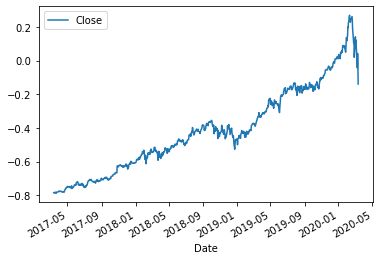

In [25]:
train.loc[dataset['Ticker']=='MSFT', ['Date', 'Close']].set_index('Date').plot()

<AxesSubplot:xlabel='Date'>

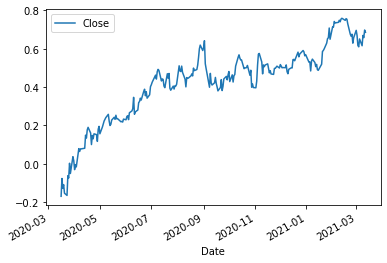

In [26]:
test.loc[dataset['Ticker']=='MSFT', ['Date', 'Close']].set_index('Date').plot()

### Convert one stock into x and y format for input to model

In [27]:
def apply_rolling(stock, trail_size):
    x = []
    y = []
    for i in range(trail_size, len(stock)):
        x.append(stock.drop(columns=['Date', 'Ticker']).iloc[i-trail_size : i].values)
        y.append(stock['Close'].iloc[i])
        
    return np.array(x), np.array(y)

In [28]:
x, y = apply_rolling(dataset.loc[dataset['Ticker']=='AAPL'], trail_size=3)

In [29]:
x.shape

(1005, 3, 5)

In [30]:
y.shape

(1005,)

### Convert all stocks into x and y for model input

In [31]:
def roll_all_stocks(dataset, trail_size):
    res = dataset.groupby('Ticker').apply(lambda x: apply_rolling(x, trail_size=trail_size))
    x = [x[0] for x in res.values]
    y = [x[1] for x in res.values]
    return np.concatenate(x), np.concatenate(y)

In [32]:
x_train, y_train = roll_all_stocks(train, trail_size)

In [33]:
x_train.shape

(7260, 30, 5)

In [34]:
y_train.shape

(7260,)

In [35]:
x_test, y_test = roll_all_stocks(test, trail_size)

In [36]:
x_test.shape

(2210, 30, 5)

In [37]:
y_test.shape

(2210,)

### Model Design

In [38]:
model = Sequential()
model.add(LSTM(units=50, input_shape=(trail_size, num_features), return_sequences=True))
model.add(Dropout(0.1))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.1))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.1))

model.add(LSTM(units=50))
model.add(Dropout(0.1))

# model.add(Dense(50, activation='relu'))
# model.add(Dense(25, activation='relu'))
model.add(Dense(1, activation='linear'))

In [39]:
# model = Sequential()
# model.add(Dense(100, input_shape=(trail_size, num_features), activation='relu'))
# model.add(Dropout(0.1))

# model.add(Flatten())

# model.add(Dense(50, activation='relu'))
# model.add(Dropout(0.1))

# model.add(Dense(10, activation='relu'))
# model.add(Dropout(0.1))

# # model.add(Dense(50, activation='relu'))
# # model.add(Dense(25, activation='relu'))
# model.add(Dense(1, activation='linear'))

In [40]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 50)            11200     
_________________________________________________________________
dropout (Dropout)            (None, 30, 50)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 50)            20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 50)            20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 50)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                2

In [41]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [42]:
history = model.fit(x_train, y_train, epochs=40, validation_data=(x_test, y_test), batch_size=32)

Epoch 1/40
227/227 [==============================] - 10s 23ms/step - loss: 0.0345 - val_loss: 0.2630
Epoch 2/40
227/227 [==============================] - 3s 15ms/step - loss: 0.0085 - val_loss: 0.0710
Epoch 3/40
227/227 [==============================] - 4s 15ms/step - loss: 0.0064 - val_loss: 0.0734
Epoch 4/40
227/227 [==============================] - 3s 15ms/step - loss: 0.0066 - val_loss: 0.0461
Epoch 5/40
227/227 [==============================] - 3s 15ms/step - loss: 0.0061 - val_loss: 0.0229
Epoch 6/40
227/227 [==============================] - 3s 15ms/step - loss: 0.0052 - val_loss: 0.0218
Epoch 7/40
227/227 [==============================] - 3s 15ms/step - loss: 0.0048 - val_loss: 0.0307
Epoch 8/40
227/227 [==============================] - 3s 15ms/step - loss: 0.0048 - val_loss: 0.0479
Epoch 9/40
227/227 [==============================] - 3s 15ms/step - loss: 0.0044 - val_loss: 0.0532
Epoch 10/40
227/227 [==============================] - 3s 15ms/step - loss: 0.0044 - val_l

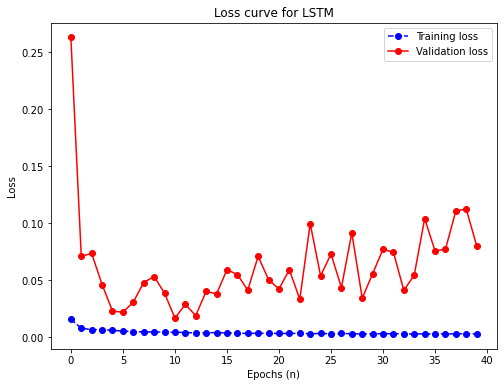

In [43]:
plt.figure(figsize=(8,6))
plt.plot(history.history['loss'], 'bo--')
plt.plot(history.history['val_loss'], 'ro-')
plt.ylabel('Loss')
plt.xlabel('Epochs (n)')
plt.legend(['Training loss', 'Validation loss'])
plt.title("Loss curve for LSTM")
plt.show()

In [44]:
def evaluate_model_rmse(y_preds, y_true):
    dummies = np.zeros((y_preds.shape[0], num_features-1))
    res = np.concatenate([y_preds, dummies], axis=1)
    pred_dollars = sc.inverse_transform(res)[:, 0]
    
    res2 = np.concatenate([np.expand_dims(y_true, axis=1), dummies], axis=1)
    true_dollars = sc.inverse_transform(res2)[:, 0]
    return np.sqrt(mean_squared_error(true_dollars, pred_dollars))

In [45]:
print("Training RMSE = {}".format(evaluate_model_rmse(model.predict(x_train), y_train)))

Training RMSE = 3.9446940891604108


In [46]:
print("Testing RMSE = {}".format(evaluate_model_rmse(model.predict(x_test), y_test)))

Testing RMSE = 33.671179464421655


#### Compare to simple baseline

In [47]:
def predict_no_change(x):
    return x[-1][0]

In [48]:
no_change_preds = np.array([predict_no_change(x) for x in x_train])
no_change_preds = np.expand_dims(no_change_preds, axis=1)

In [49]:
evaluate_model_rmse(no_change_preds, y_train)

3.303356760687281

In [50]:
no_change_preds = np.array([predict_no_change(x) for x in x_test])
no_change_preds = np.expand_dims(no_change_preds, axis=1)

In [51]:
evaluate_model_rmse(no_change_preds, y_test)

7.237492451243753